In [1]:
"""
 m examples consist of n=3 features
 each label will look like sum(a[i]*x[i]) + x[0]*x[5] - x[3]*x[7]  + noise
"""

import torch

def generate_data(A, m, noise):
    n = len(A)
    X = torch.normal(0.0, 1.0, (m, n), dtype = torch.float64)
    #print(X.shape)
    y = torch.matmul(X, A) + X[:, 0] * X[:, 5] - X[:, 3] * X[:, 7] + torch.normal(0.0, noise, (m,))
    # print(y.shape)
    return X, y.unsqueeze(1)

train_count, test_count, noise = 100000, 1000, 10.5
coeffs = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5, -0.4, -0.3, -0.2, -0.1], dtype = torch.float64)
X_train, y_train = generate_data(coeffs, train_count, noise)
print(X_train.shape, y_train.shape)
X_test, y_test = generate_data(coeffs, test_count, noise)
print(X_test.shape, y_test.shape)

torch.Size([100000, 27]) torch.Size([100000, 1])
torch.Size([1000, 27]) torch.Size([1000, 1])


In [2]:
class MLP(torch.nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(torch.nn.Linear(layer_sizes[i], layer_sizes[i + 1], dtype = torch.float64))
            if i + 2 != len(layer_sizes):
                layers.append(torch.nn.Sigmoid())
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

mlp = MLP([X_train.shape[1], 256, 256, 256, 1])
mlp(X_test[[0, 1, 2, 3, 4]] - y_test[[0, 1, 2, 3, 4]])

tensor([[-0.4179],
        [-0.4186],
        [-0.4168],
        [-0.4033],
        [-0.4167]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [3]:
import random

optimiser = torch.optim.AdamW(mlp.parameters())
loss_function = torch.nn.MSELoss()
train_losses, test_losses = [], []
for epoch in range(100):
    # train
    idx = list(range(X_train.shape[0]))
    random.shuffle(idx)
    total_loss, total_count = 0.0, 1e-38
    for start in range(0, X_train.shape[0], 128):
        x = X_train[idx[start : start + 128]]
        if x.shape[0] != 128:
            # take only full batches for training
            continue
        y = y_train[idx[start : start + 128]]
        #print(x.shape, y.shape)
        optimiser.zero_grad()
        output = mlp(x)
        # loss = sum((output - y) ** 2)
        loss = loss_function(output, y) / x.shape[0]
        total_loss += loss.item()
        total_count += 1
        loss.backward()
        optimiser.step()
    train_losses.append(total_loss / total_count)
    
    # test
    idx = list(range(X_test.shape[0]))
    # no shuffling!
    total_loss, total_count = 0.0, 1e-38
    with torch.no_grad():
        for start in range(0, X_test.shape[0], 128):
            x = X_test[idx[start : start + 128]]
            y = y_test[idx[start : start + 128]]
            output = mlp(x)
            # loss = sum((output - y) ** 2)
            loss = loss_function(output, y)
            total_loss += loss.item()
            total_count += x.shape[0]
        test_losses.append(total_loss / total_count)

    #print epoch results
    print("Epoch {}: {:.5f} {:.5f}".format(epoch, train_losses[-1], test_losses[-1]))
        

Epoch 0: 0.88443 0.82475
Epoch 1: 0.87993 0.82733
Epoch 2: 0.87884 0.82300
Epoch 3: 0.87787 0.82375
Epoch 4: 0.87802 0.82079
Epoch 5: 0.87745 0.82008
Epoch 6: 0.87618 0.81948
Epoch 7: 0.87485 0.81858
Epoch 8: 0.87402 0.82030
Epoch 9: 0.87317 0.81879
Epoch 10: 0.87207 0.81666
Epoch 11: 0.87186 0.81783
Epoch 12: 0.87103 0.81609
Epoch 13: 0.87103 0.81568
Epoch 14: 0.87006 0.81393
Epoch 15: 0.86949 0.81319
Epoch 16: 0.86802 0.81365
Epoch 17: 0.86646 0.80795
Epoch 18: 0.86523 0.80713
Epoch 19: 0.86401 0.80222
Epoch 20: 0.86366 0.80325
Epoch 21: 0.86311 0.80630
Epoch 22: 0.86266 0.80426
Epoch 23: 0.86239 0.80351
Epoch 24: 0.86128 0.80571
Epoch 25: 0.86130 0.80445
Epoch 26: 0.86064 0.80720
Epoch 27: 0.86033 0.80294
Epoch 28: 0.85952 0.80516
Epoch 29: 0.85898 0.80595
Epoch 30: 0.85854 0.80646
Epoch 31: 0.85802 0.80855
Epoch 32: 0.85718 0.80412
Epoch 33: 0.85655 0.80569
Epoch 34: 0.85581 0.80377
Epoch 35: 0.85545 0.80605
Epoch 36: 0.85423 0.80599
Epoch 37: 0.85354 0.80927
Epoch 38: 0.85272 0.80

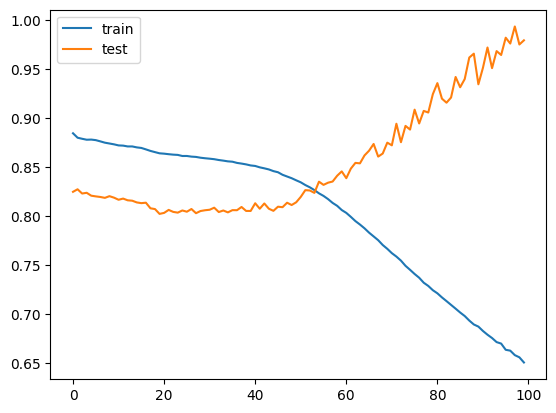

In [4]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label = "train")
plt.plot(test_losses, label = "test")
plt.legend()
plt.show()